In [1]:
!pip install Obspy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

def plot_results(trace, p_arrival):
    time = np.arange(len(trace))
    plt.figure(figsize=(12, 6))
    plt.plot(time, trace)
    plt.axvline(x=p_arrival, color='r', linestyle='--', label='P-wave arrival')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Seismic Trace with P-wave Arrival')
    plt.legend()
    plt.show()

In [4]:
def calculate_aic_reduced(trace):
    n = len(trace)
    aic = np.zeros(n)
    idx = 0
    for k in range(1, n-1):
        if k%6!=0:
          aic[k] = np.inf
          continue
        var1 = np.var(trace[:k])
        var2 = np.var(trace[k:])

        if var1 <= 0 or var2 <= 0:
            aic[k] = np.inf
        else:
            aic[k] = k * np.log(var1) + (n - k - 1) * np.log(var2)

    return aic

In [5]:
def detect_p_wave_reduced(trace, window_size=100):
    # Calculate AIC
    aic = calculate_aic_reduced(trace)
    p_arrival = 0
    min_idx=np.argmin(aic)
    p_arrival = min_idx

    return p_arrival

In [7]:
def evaluate_mseed_file(file_path):
    # Read the MSEED file
    st = read(file_path)

    #st.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    trace = st.traces[0].data

    p_arrival_train_3 = detect_p_wave_reduced(trace)/6.625
    print(f"P-wave arrival detected at sample {p_arrival_train_3}")
    plot_results(trace, p_arrival_train_3*6.625)
    return p_arrival_train_3


Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-09-10HR00_evid00075.mseed
P-wave arrival detected at sample 46831.698113207545


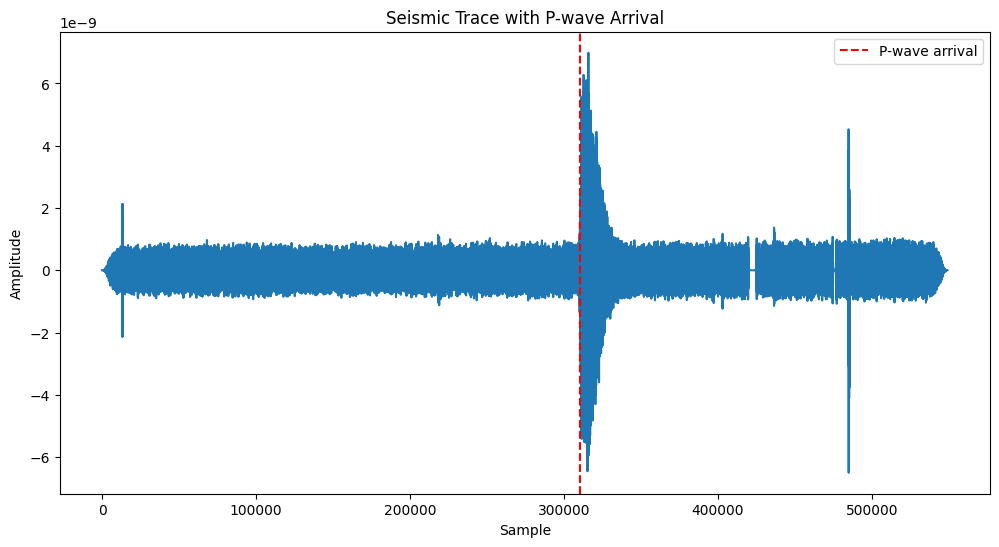

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-14HR00_evid00081.mseed
P-wave arrival detected at sample 63507.622641509435


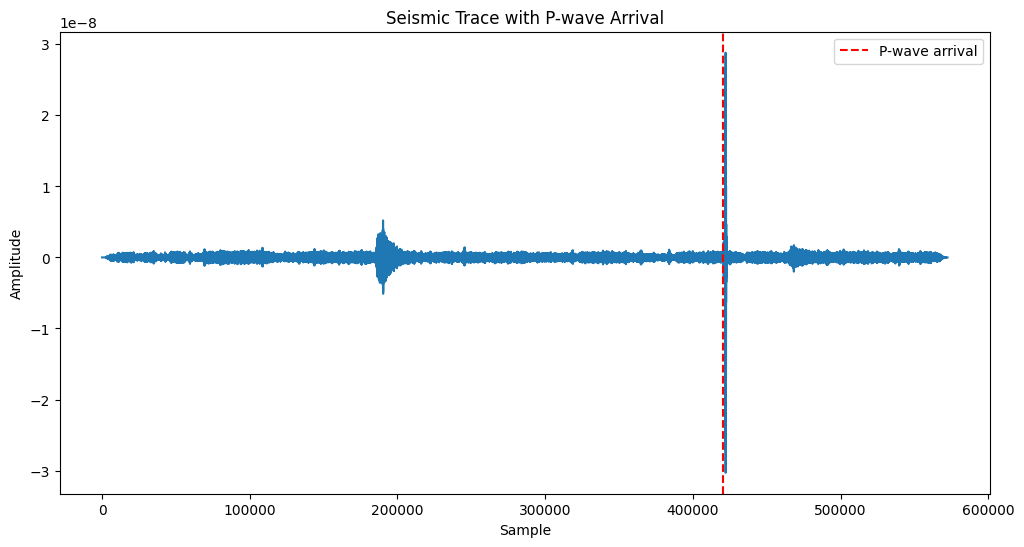

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-06HR00_evid00079.mseed
P-wave arrival detected at sample 18589.584905660377


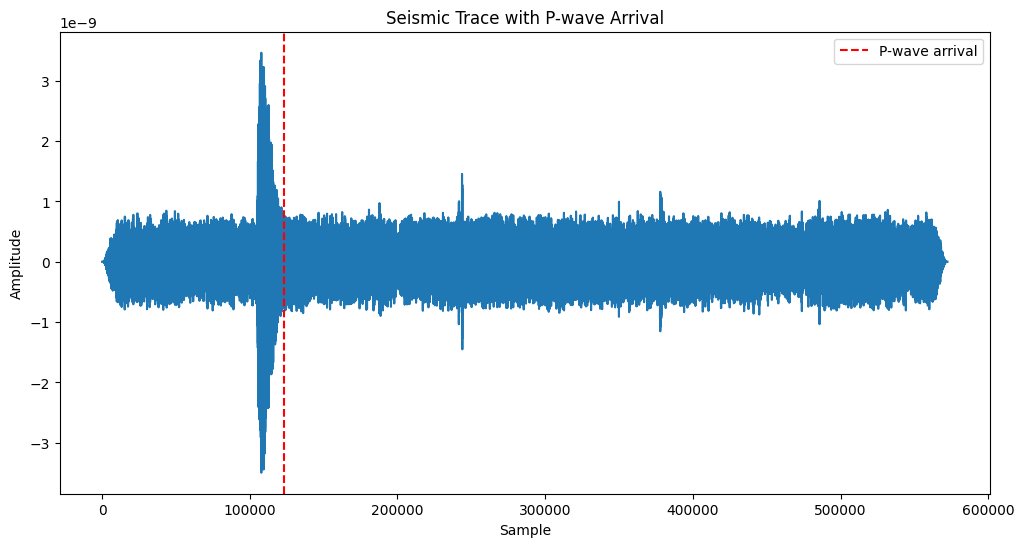

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1972-11-08HR00_evid00080.mseed
P-wave arrival detected at sample 67399.24528301887


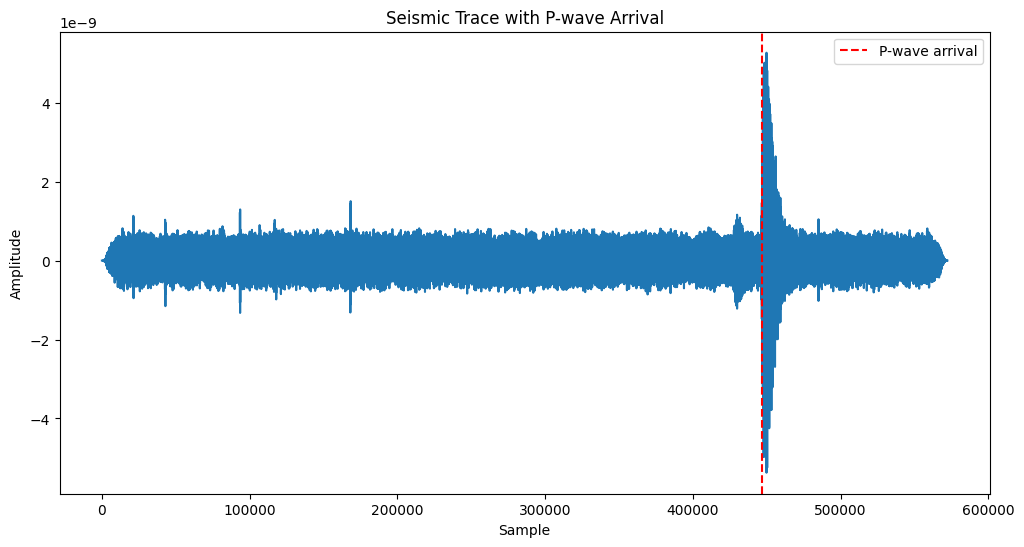

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1973-07-31HR00_evid00123.mseed
P-wave arrival detected at sample 35709.28301886792


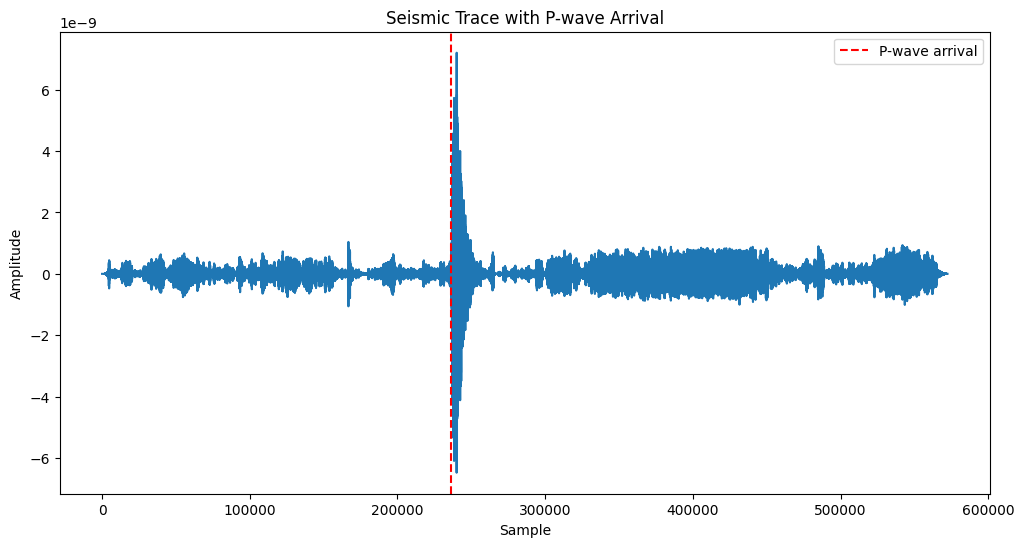

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-11-11HR00_evid00160.mseed
P-wave arrival detected at sample 63517.58490566038


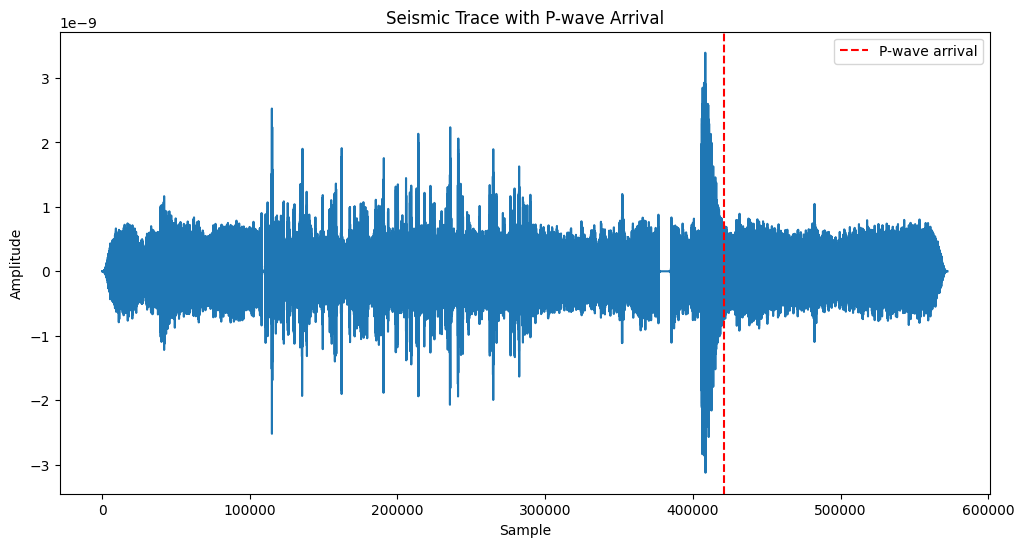

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-05-19HR00_evid00146.mseed
P-wave arrival detected at sample 69350.94339622642


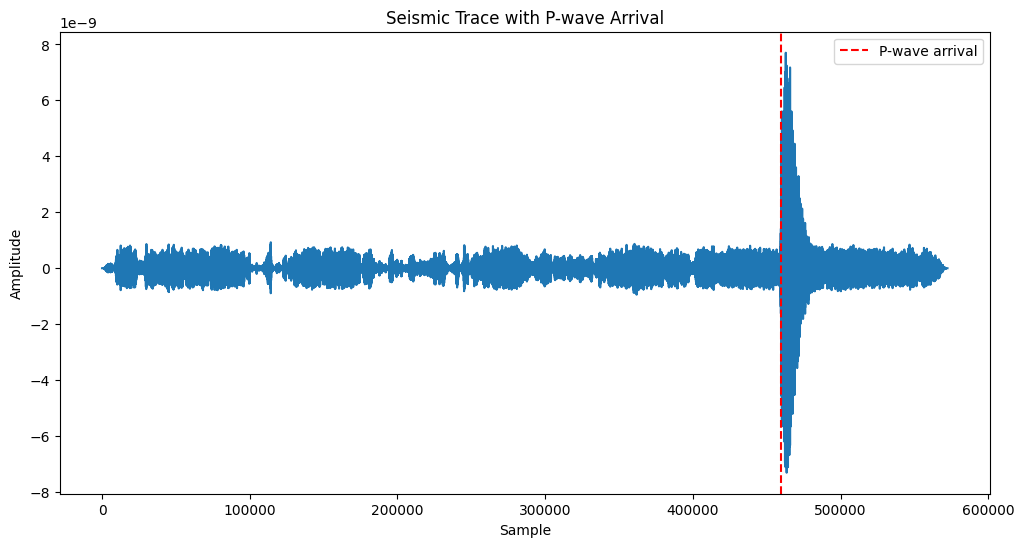

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-12-15HR00_evid00172.mseed
P-wave arrival detected at sample 44227.018867924526


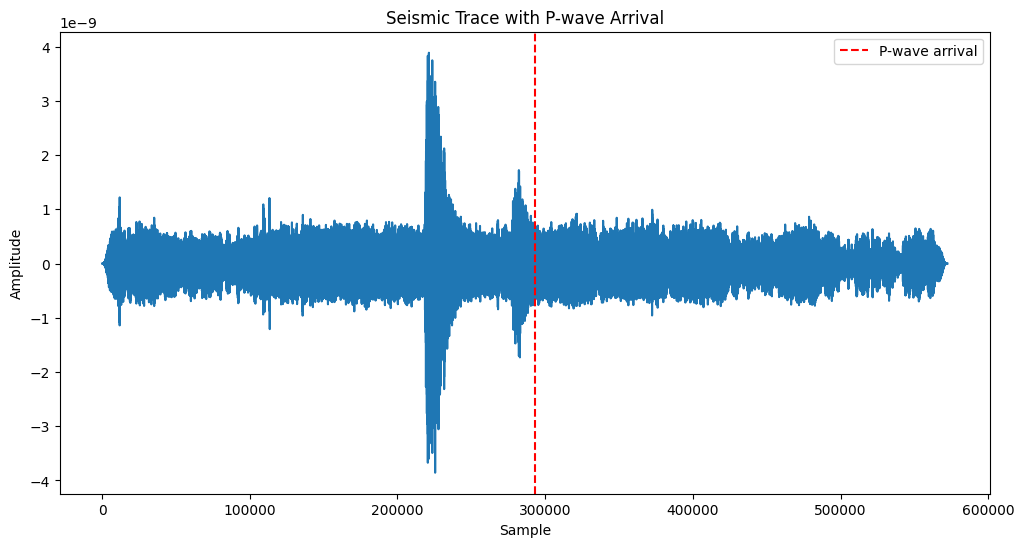

Processing file: /content/drive/MyDrive/SpaceApps/data/lunar/test/data/S16_GradeA/xa.s16.00.mhz.1974-12-25HR00_evid00174.mseed


In [ ]:
import os
import glob

def process_files_in_directory(directory, extension):
    search_pattern = os.path.join(directory, f'*.{extension}')
    df = pd.DataFrame(['filename', 'time_rel(sec)'])
    for file_path in glob.glob(search_pattern):
        print(f'Processing file: {file_path}')
        arrival_time = evaluate_mseed_file(file_path)


def process_files_in_directory(directory, extension):
    df = pd.DataFrame(['filename', 'time_rel(sec)'])
    search_pattern = os.path.join(directory, f'*.{extension}')

    for file_path in glob.glob(search_pattern):
        print(f'Processing file: {file_path}')

        # Extract filename
        filename = os.path.basename(file_path)

        # Evaluate the file to get arrival time
        arrival_time = evaluate_mseed_file(file_path)
        new_row = pd.DataFrame({'Filename': [filename], 'Arrival Time': [arrival_time]})

        # Append to DataFrame
        df = pd.concat([df, new_row], ignore_index=True)

# Example usage
folders = ['S16_GradeA', 'S16_GradeB', 'S15_GradeA', 'S15_GradeB', 'S12_GradeB']
for folder in folders:
  path_prefix = "/content/drive/MyDrive/SpaceApps"
  data_directory = path_prefix + f'/data/lunar/test/data/{folder}/'

  extension = 'mseed'
  cur_df = process_files_in_directory(data_directory, extension)
  cur_df.to_csv(f"{folder}_catlog_lunar.csv", index=False)